# Playground

In [55]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.append("./code")

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset

import logging
logging.basicConfig(format="%(asctime)s - %(levelname)s: %(message)s", level=logging.INFO, datefmt="%I:%M:%S")

from dataset import *
from plots import *
from models import *
from utils import *

fix_seed()

## Metadata Summary

Let's load the metadata for the segmented single-cell images.

In [57]:
metadata = load_metadata()

In [58]:
metadata.head()

,Unnamed: 0,Multi_Cell_Image_Id,Multi_Cell_Image_Name,Single_Cell_Image_Id,Single_Cell_Image_Name,TableNumber,ImageNumber,Image_FileName_DAPI,Image_PathName_DAPI,Image_FileName_Tubulin,Image_PathName_Tubulin,Image_FileName_Actin,Image_PathName_Actin,Image_Metadata_Plate_DAPI,Image_Metadata_Well_DAPI,Replicate,Image_Metadata_Compound,Image_Metadata_Concentration,moa
0,0,433,Week10_200907_B02_s1_w18E215662-2CF7-4739-93F3...,0,Week10_200907_B02_s1_w18E215662-2CF7-4739-93F3...,0,1,Week10_200907_B02_s1_w18E215662-2CF7-4739-93F3...,Week10_40111,Week10_200907_B02_s1_w2D492FCE4-15C2-4C66-99A5...,Week10_40111,Week10_200907_B02_s1_w436D0A3BC-098D-4271-B5AA...,Week10_40111,Week10_40111,B02,1,DMSO,0.0,DMSO
1,1,433,Week10_200907_B02_s1_w18E215662-2CF7-4739-93F3...,1,Week10_200907_B02_s1_w18E215662-2CF7-4739-93F3...,0,1,Week10_200907_B02_s1_w18E215662-2CF7-4739-93F3...,Week10_40111,Week10_200907_B02_s1_w2D492FCE4-15C2-4C66-99A5...,Week10_40111,Week10_200907_B02_s1_w436D0A3BC-098D-4271-B5AA...,Week10_40111,Week10_40111,B02,1,DMSO,0.0,DMSO
2,2,433,Week10_200907_B02_s1_w18E215662-2CF7-4739-93F3...,2,Week10_200907_B02_s1_w18E215662-2CF7-4739-93F3...,0,1,Week10_200907_B02_s1_w18E215662-2CF7-4739-93F3...,Week10_40111,Week10_200907_B02_s1_w2D492FCE4-15C2-4C66-99A5...,Week10_40111,Week10_200907_B02_s1_w436D0A3BC-098D-4271-B5AA...,Week10_40111,Week10_40111,B02,1,DMSO,0.0,DMSO
3,3,433,Week10_200907_B02_s1_w18E215662-2CF7-4739-93F3...,3,Week10_200907_B02_s1_w18E215662-2CF7-4739-93F3...,0,1,Week10_200907_B02_s1_w18E215662-2CF7-4739-93F3...,Week10_40111,Week10_200907_B02_s1_w2D492FCE4-15C2-4C66-99A5...,Week10_40111,Week10_200907_B02_s1_w436D0A3BC-098D-4271-B5AA...,Week10_40111,Week10_40111,B02,1,DMSO,0.0,DMSO
4,4,433,Week10_200907_B02_s1_w18E215662-2CF7-4739-93F3...,4,Week10_200907_B02_s1_w18E215662-2CF7-4739-93F3...,0,1,Week10_200907_B02_s1_w18E215662-2CF7-4739-93F3...,Week10_40111,Week10_200907_B02_s1_w2D492FCE4-15C2-4C66-99A5...,Week10_40111,Week10_200907_B02_s1_w436D0A3BC-098D-4271-B5AA...,Week10_40111,Week10_40111,B02,1,DMSO,0.0,DMSO


In [59]:
metadata.shape

(488396, 19)

Let's explores the distribution over treatments.

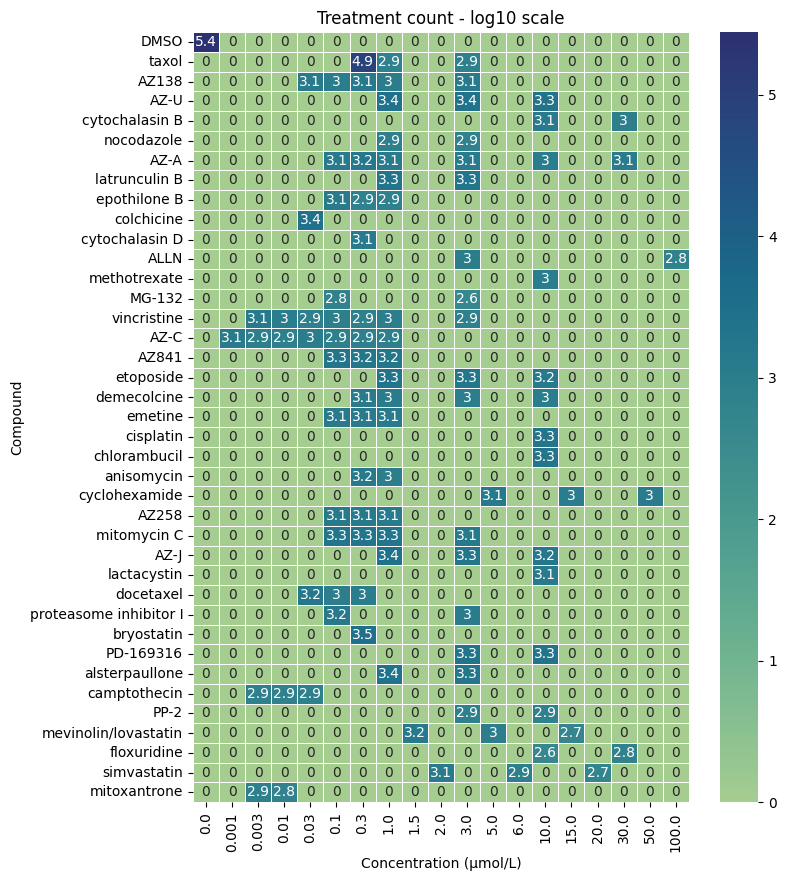

In [60]:
plot_treatment_heatmap(metadata)

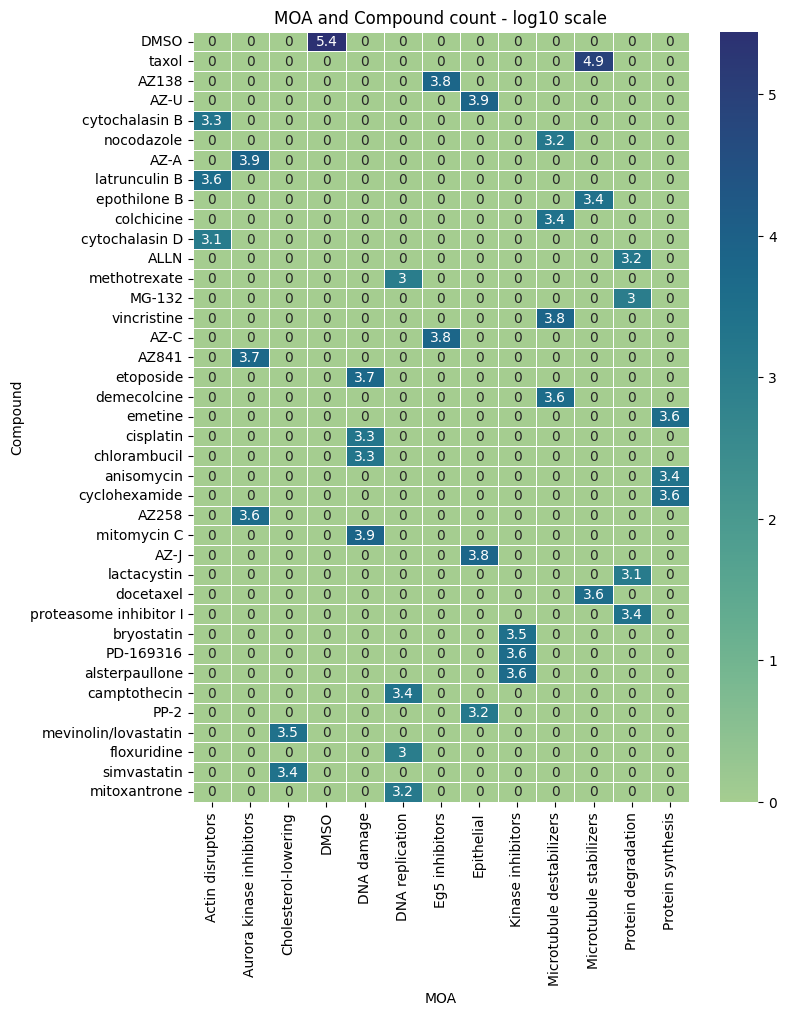

In [61]:
plot_compound_and_MOA(metadata)

A treatment always has the same mechanism of action (MOA). The BBBC021 dataset has primarly been used to predict the MOA given a picture. We will explore how well it predicts treatments. Notice some compounds has the MOA on the single-cell.

## Stratified - Subset of Dataset

We will only use a subset of the treatments. We will be needing at least 3 concentration levels for a compound, since we will impute single-cell images with none-boundary concentrations - more on this later. Notice the concentrations $0.1$, $0.3$ and $1$ appear frequently together for most compounds. So we will use compounds which have single-cell images for these 3 concentration levels.

In [62]:
whitelist = get_treatment_whitelist()
whitelist

[('AZ138', 0.1),
 ('AZ138', 0.3),
 ('AZ138', 1),
 ('AZ-A', 0.1),
 ('AZ-A', 0.3),
 ('AZ-A', 1),
 ('epothilone B', 0.1),
 ('epothilone B', 0.3),
 ('epothilone B', 1),
 ('vincristine', 0.1),
 ('vincristine', 0.3),
 ('vincristine', 1),
 ('AZ-C', 0.1),
 ('AZ-C', 0.3),
 ('AZ-C', 1),
 ('AZ841', 0.1),
 ('AZ841', 0.3),
 ('AZ841', 1),
 ('emetine', 0.1),
 ('emetine', 0.3),
 ('emetine', 1),
 ('AZ258', 0.1),
 ('AZ258', 0.3),
 ('AZ258', 1),
 ('mitomycin C', 0.1),
 ('mitomycin C', 0.3),
 ('mitomycin C', 1),
 ('DMSO', 0)]

In [52]:
blacklist = get_treatment_blacklist()
blacklist

[('AZ138', 0.3), ('AZ-A', 0.3), ('epothilone B', 0.3), ('vincristine', 0.3)]

In [63]:
selected = [treatment for treatment in whitelist if treatment not in blacklist]

In [110]:
stratified_metadata = stratify_metadata(metadata, 100, whitelist=selected)
stratified_images = load_images_from_metadata(stratified_metadata)

print(f"{stratified_images.shape[0]} images")

2400 images


In [95]:
stratified_metadata.head()

,Unnamed: 0,Multi_Cell_Image_Id,Multi_Cell_Image_Name,Single_Cell_Image_Id,Single_Cell_Image_Name,TableNumber,ImageNumber,Image_FileName_DAPI,Image_PathName_DAPI,Image_FileName_Tubulin,Image_PathName_Tubulin,Image_FileName_Actin,Image_PathName_Actin,Image_Metadata_Plate_DAPI,Image_Metadata_Well_DAPI,Replicate,Image_Metadata_Compound,Image_Metadata_Concentration,moa
4799,4799,505,Week10_200907_C08_s1_w14962D4AB-2A48-4B3B-BBE1...,0,Week10_200907_C08_s1_w14962D4AB-2A48-4B3B-BBE1...,0,65,Week10_200907_C08_s1_w14962D4AB-2A48-4B3B-BBE1...,Week10_40111,Week10_200907_C08_s1_w2F9EB49AC-DE29-415C-A7A0...,Week10_40111,Week10_200907_C08_s1_w430736F56-E317-45DF-8A49...,Week10_40111,Week10_40111,C08,1,AZ138,0.1,Eg5 inhibitors
4800,4800,505,Week10_200907_C08_s1_w14962D4AB-2A48-4B3B-BBE1...,1,Week10_200907_C08_s1_w14962D4AB-2A48-4B3B-BBE1...,0,65,Week10_200907_C08_s1_w14962D4AB-2A48-4B3B-BBE1...,Week10_40111,Week10_200907_C08_s1_w2F9EB49AC-DE29-415C-A7A0...,Week10_40111,Week10_200907_C08_s1_w430736F56-E317-45DF-8A49...,Week10_40111,Week10_40111,C08,1,AZ138,0.1,Eg5 inhibitors
3908,3908,482,Week10_200907_C06_s1_w1F2F3CEBD-0E25-4C61-87B3...,0,Week10_200907_C06_s1_w1F2F3CEBD-0E25-4C61-87B3...,0,57,Week10_200907_C06_s1_w1F2F3CEBD-0E25-4C61-87B3...,Week10_40111,Week10_200907_C06_s1_w2D8884334-2C3F-4705-AB78...,Week10_40111,Week10_200907_C06_s1_w4C5D2C268-B26B-43F8-BF7C...,Week10_40111,Week10_40111,C06,1,AZ138,1.0,Eg5 inhibitors
3909,3909,482,Week10_200907_C06_s1_w1F2F3CEBD-0E25-4C61-87B3...,1,Week10_200907_C06_s1_w1F2F3CEBD-0E25-4C61-87B3...,0,57,Week10_200907_C06_s1_w1F2F3CEBD-0E25-4C61-87B3...,Week10_40111,Week10_200907_C06_s1_w2D8884334-2C3F-4705-AB78...,Week10_40111,Week10_200907_C06_s1_w4C5D2C268-B26B-43F8-BF7C...,Week10_40111,Week10_40111,C06,1,AZ138,1.0,Eg5 inhibitors
51724,51724,1155,Week1_150607_G08_s1_w1B6C24C30-E50D-4513-9B0A-...,0,Week1_150607_G08_s1_w1B6C24C30-E50D-4513-9B0A-...,1,225,Week1_150607_G08_s1_w1B6C24C30-E50D-4513-9B0A-...,Week1_22123,Week1_150607_G08_s1_w29F6758F6-C6FF-4623-A18D-...,Week1_22123,Week1_150607_G08_s1_w49ED70C4A-9852-4CE8-B5D5-...,Week1_22123,Week1_22123,G08,1,AZ-A,0.1,Aurora kinase inhibitors


The paper, [Capturing Single-Cell Phenotypic Variation
via Unsupervised Representation Learning - Lafarge et al](http://proceedings.mlr.press/v102/lafarge19a/lafarge19a.pdf) normalize single-cell images channel-wise, so will we. It is plausible that the signal strength of an image is different between single-cell image batches - and channels. Thus, such a normalization is not unreasonable. 

In [96]:
stratified_images = normalize_image_channel_wise(stratified_images)

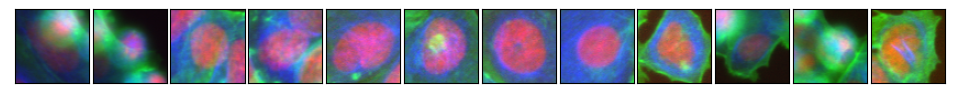

In [97]:
plot_images(stratified_images[:12])

Notice in the above segmented single-cell images, e.g. image 2 and 3, they still contain multiple single-cell due to the proximity of the single-cells in the original unsegmented image.

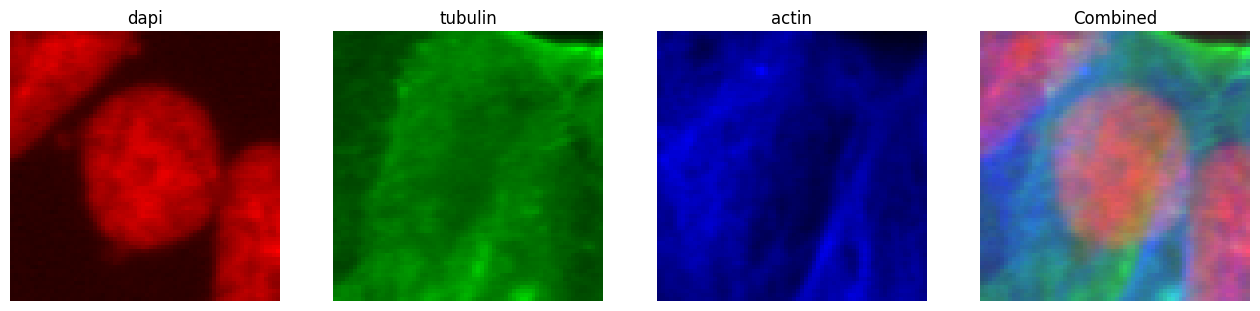

In [98]:
plot_channels(stratified_images[2])

## Model - Training

Let's train a conditional diffusion model to generate single-cell images given a treatment specification.

In [99]:
compound_types = list(set([treatment[0] for treatment in whitelist]))
concentration_types = list(set([treatment[1] for treatment in whitelist]))

In [100]:
train_metadata = stratified_metadata
train_images = stratified_images

In [101]:
train_images = normalized_to_pseudo_zscore(train_images)
train_images = crop_images(train_images)

In [ ]:
train_conditional_diffusion_model(train_metadata, train_images, compound_types, concentration_types, epochs=2, epoch_sample_times=2, batch_size=2)

## Model - Load pretrained

Actually, we have already trained a conditional diffusion model. Let's load it.

In [ ]:
unet = UNet()
unet.load_state_dict(torch.load("./models/DDPM_Unconditional/ckpt.pt"))
diffusion = Diffusion()
sampled_images = diffusion.sample(unet, N_images=1)

## Results

Let's see how this conditional diffusion model improved throughout training.

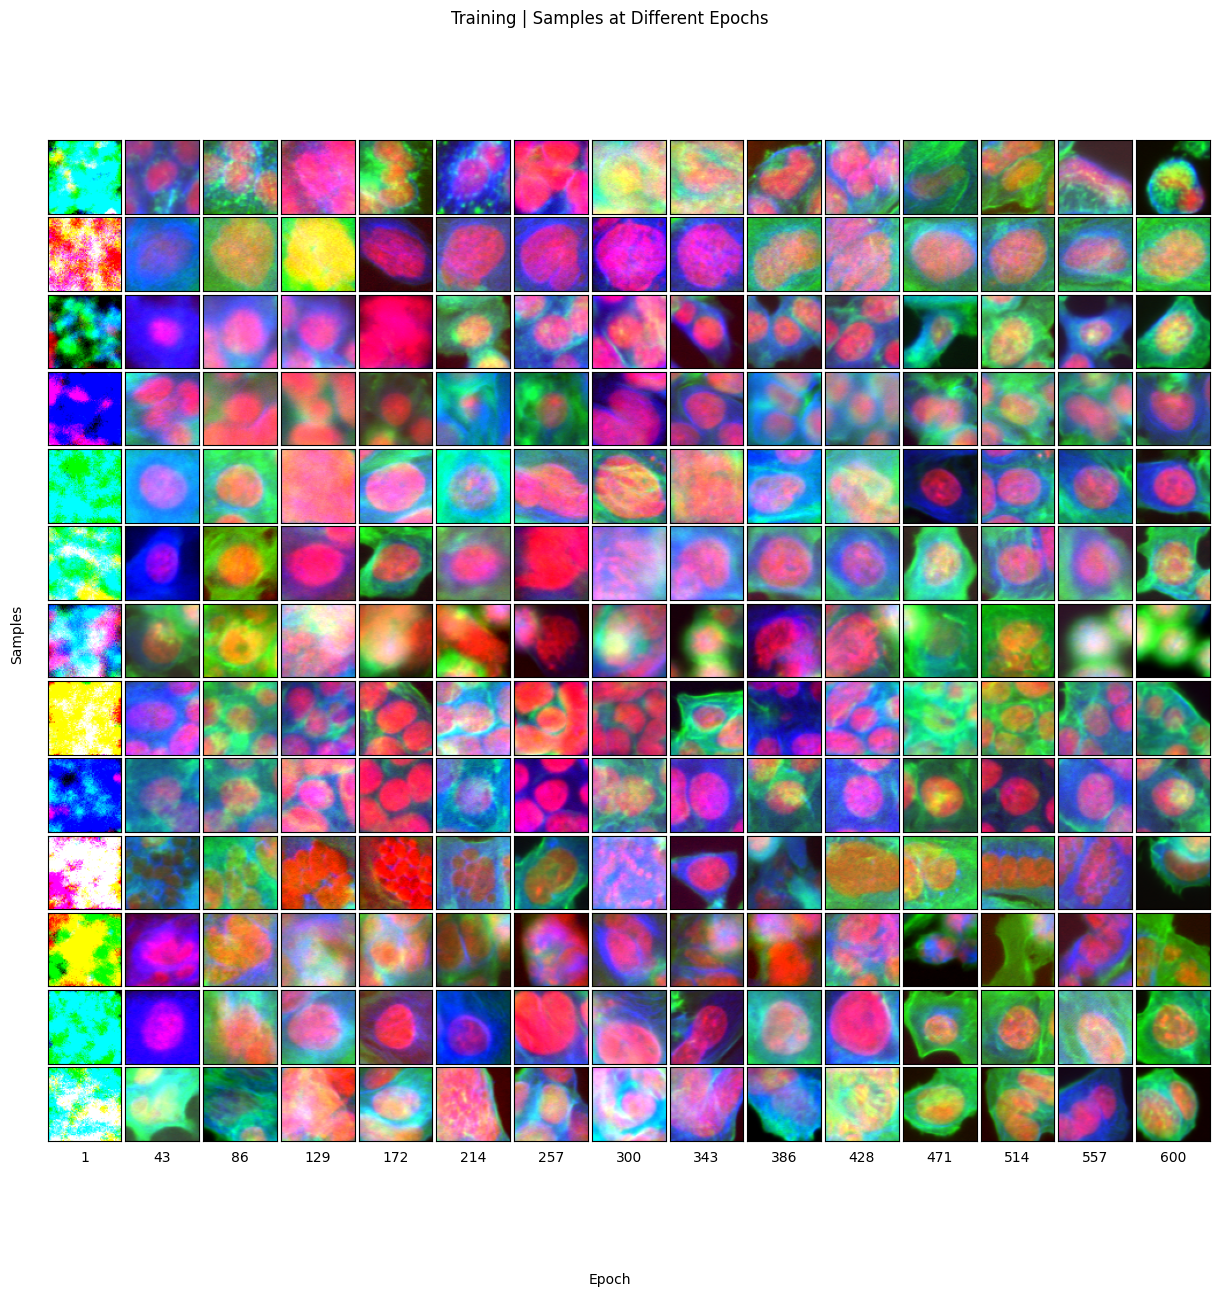

In [21]:
epoch_images, epochs = load_epoch_images("./results/DDPM_Conditional/")
plot_epoch_sample_series(epoch_images, epochs)

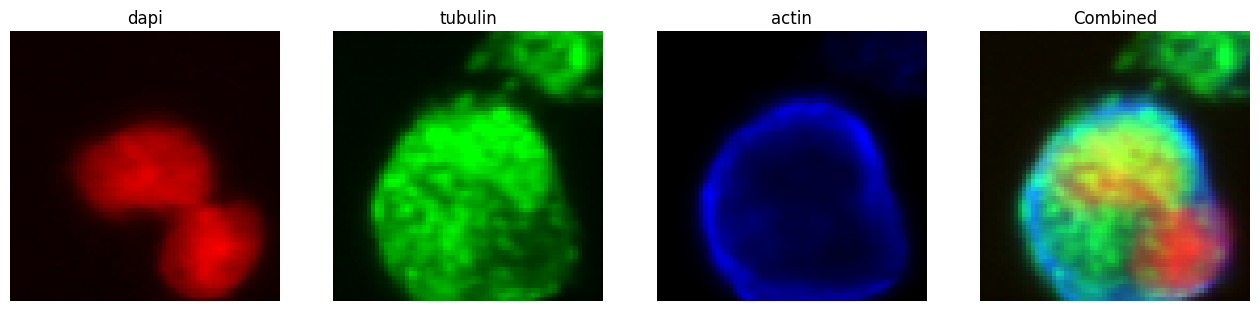

In [22]:
plot_channels(epoch_images[-1][0])

# Evaluation

Now it's time for evaluating the generated images. We have trained a model to predict the compound of a single-cell image and the concentration.

In [ ]:
n_classes = len(get_all_MOA_types())
unet = UNet_conditional(n_classes)
unet.load_state_dict(torch.load("./models/DDPM_Conditional/ckpt1.pt", map_location=torch.device('cpu')))
diffusion = Diffusion_conditional()

classifier = Treatment_classifier2()
classifier.load_state_dict(torch.load("./models/Classifier/ckpt.pt"))

In [ ]:
N_images = 2

labels = torch.zeros(N_images, dtype=torch.long)

# compute mean and std
concentrations = torch.tensor(np.array(metadata["Image_Metadata_Concentration"], dtype=np.float32))
concentrations = log_transform(concentrations)
concentration_mean, concentration_std = concentrations.mean(), concentrations.std()

concentrations = torch.ones((N_images, 1))
concentrations = (concentrations / concentration_mean) / concentration_std
y_regr = log_transform(concentrations)

sampled_images = diffusion.sample(unet, N_images=N_images, labels=labels, y_regr=y_regr)

In [ ]:
sampled_images

In [ ]:
pred_moa, _ = classifier(sampled_images)
#pred_moa, _ = classifier(train_images[:N_images])

pred_moa = pred_moa.max(1)[1]

In [ ]:
accuracy = (torch.sum(pred_moa == labels)).numpy() / N_images
accuracy

## Compound

In [11]:
class Compound_classifier(nn.Module): 
    def __init__(self,  N_compounds, c_in=3):
        super().__init__()
        
        self.bulk = nn.Sequential(
            nn.Conv2d(in_channels=c_in, out_channels=32, kernel_size=5, padding=2),
            # 64h * 64w * 32ch
            nn.MaxPool2d(2),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),

            # 32h * 32w * 32ch
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, padding=0),
            # 28h * 28w * 32ch
            nn.MaxPool2d(2),
            # 14h * 14w * 32ch
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),

            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, padding=0),
            # 10h * 10w * 32ch
            nn.MaxPool2d(2),
            # 5h * 5w * 32ch
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),

            #  5h * 5w * 32ch
            nn.Conv2d(in_channels=32, out_channels=2*256, kernel_size=5, padding=0),
            # 1h * 1w * 512ch
            nn.BatchNorm2d(2*256),
            nn.Flatten()
        )
        
        bulk_outs = 2*256
        
        self.out = nn.Sequential(
            nn.Linear(bulk_outs, 16),
            nn.Tanh(),
            nn.Linear(16, N_compounds))
        
    def forward(self, images):
        x = self.bulk(images)
        y = self.out(x)
        return y

In [12]:
def train_Compound_classifier(train_metadata, train_images, validation_metadata, validation_images, lr=0.001, epochs=50, batch_size=32, epoch_sample_times=10):
    run_name = "MOA_Classifier"
    make_result_folders(run_name)
    
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    logging.info(f"Using device: {device}")
    
    # prepare train dataset
    moa_to_id, _ = get_MOA_mappings()
    train_moa = torch.from_numpy(np.array([moa_to_id[m] for m in train_metadata["moa"]]))

    train_dataset = TensorDataset(train_images, train_moa)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # prepare validation set
    moa_to_id, _ = get_MOA_mappings()
    validation_moa = torch.from_numpy(np.array([moa_to_id[m] for m in validation_metadata["moa"]]))

    validation_dataset = TensorDataset(validation_images, validation_moa)
    validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

    training_result = {}
    
    moa_loss = nn.CrossEntropyLoss()
    
    model = MOA_classifier().to(device)
    
    training_result["train_loss"] = []      # (epoch, loss)
    training_result["validation_loss"] = [] # (epoch, loss)
    training_result["train_accuracy"] = []      # (epoch, accuracy)
    training_result["validation_accuracy"] = [] # (epoch, accuracy)
    
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=1e-5)
    
    k = 0
    epoch_sample_points = torch.linspace(1, epochs, epoch_sample_times, dtype=torch.int32)
    
    for epoch in range(1, epochs+1):
        logging.info(f"Starting epoch {epoch}:")
        
        train_batch_loss = []
        train_batch_accuracy = []

        pbar = tqdm(train_dataloader)
        for i, (images, target_moa) in enumerate(pbar):
            images = images.to(device)
            target_moa = target_moa.to(device)

            pred_moa = model(images)
            loss = moa_loss(pred_moa, target_moa)

            optimizer.zero_grad()
            loss.backward()
            #torch.nn.utils.clip_grad_norm_(model.parameters(), 1_000)
            optimizer.step()
            
            train_batch_loss.append(loss.detach().cpu())
            
            accuracy = (torch.sum(pred_moa.max(1)[1] == target_moa)).cpu().numpy() / len(images)
            train_batch_accuracy.append(accuracy)     
                
            pbar.set_postfix(loss=loss.item())

        # store training loss
        training_result["train_loss"].append((epoch, np.mean(np.array(train_batch_loss))))
        training_result["train_accuracy"].append((epoch, np.mean(np.array(train_batch_accuracy))))
        
        if epoch == epoch_sample_points[k]:
            k += 1
            
            with torch.no_grad():
                model.eval()
                
                validation_batch_loss = []
                validation_batch_accuracy = []
        
                for i, (images, target_moa) in enumerate(validation_dataloader):
                    images = images.to(device)
                    target_moa = target_moa.to(device)

                    pred_moa = model(images)
                    loss = moa_loss(pred_moa, target_moa)
                    
                    validation_batch_loss.append(loss.detach().cpu())
               
                    accuracy = (torch.sum(pred_moa.max(1)[1] == target_moa)).cpu().numpy() / len(images)
                    validation_batch_accuracy.append(accuracy)     
            
                training_result["validation_loss"].append((epoch, np.mean(np.array(validation_batch_loss))))
                training_result["validation_accuracy"].append((epoch, np.mean(np.array(validation_batch_accuracy))))

                model.train()
            
            # store latest model and performance
            logging.info("saving")
            torch.save(model.state_dict(), os.path.join("models", run_name, f"ckpt{epoch}.pt"))
            save_dict(training_result, os.path.join("results", run_name, "train_results.pkl"))  

    torch.save(model.state_dict(), os.path.join("models", run_name, f"ckpt.pt"))

In [9]:
blacklist = []
validation_metadata = stratify_metadata(metadata, 20, blacklist=blacklist)
train_metadata = stratify_metadata(metadata, 120, blacklist=blacklist).drop(validation_metadata.index, errors="ignore")

_train_images = load_images_from_metadata(train_metadata)
_train_images = normalize_image_channel_wise(_train_images)
_train_images = normalized_to_pseudo_zscore(_train_images)
train_images = crop_images(_train_images)

_validation_images = load_images_from_metadata(validation_metadata)
_validation_images = normalize_image_channel_wise(_validation_images)
_validation_images = normalized_to_pseudo_zscore(_validation_images)
validation_images = crop_images(_validation_images)

train_MOA_classifier(train_metadata, train_images, validation_metadata, validation_images)

08:47:51 - INFO: Using device: cpu
08:47:51 - INFO: Starting epoch 1:
100%|██████████████████████████████| 207/207 [00:12<00:00, 16.34it/s, loss=2.46]
08:48:05 - INFO: saving
08:48:05 - INFO: Starting epoch 2:
100%|██████████████████████████████| 207/207 [00:13<00:00, 15.74it/s, loss=2.28]
08:48:18 - INFO: Starting epoch 3:
100%|██████████████████████████████| 207/207 [00:13<00:00, 15.71it/s, loss=2.31]
08:48:31 - INFO: Starting epoch 4:
100%|██████████████████████████████| 207/207 [00:13<00:00, 15.81it/s, loss=2.18]
08:48:44 - INFO: Starting epoch 5:
 60%|█████████████████▉            | 124/207 [00:09<00:06, 12.64it/s, loss=2.05]

In [10]:
classifier_training_data = load_dict("results/MOA_Classifier/train_results.pkl")

In [11]:
plot_treatment_classifier_accuracy(classifier_training_data)

## Regression

In [37]:
class Concentration_Regressor(nn.Module): 
    def __init__(self, c_in=3, N_moas=13):
        super().__init__()
        
        self.bulk = nn.Sequential(
            nn.Conv2d(in_channels=c_in, out_channels=32, kernel_size=5, padding=2),
            # 64h * 64w * 32ch
            nn.MaxPool2d(2),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),

            # 32h * 32w * 32ch
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, padding=0),
            # 28h * 28w * 32ch
            nn.MaxPool2d(2),
            # 14h * 14w * 32ch
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),

            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, padding=0),
            # 10h * 10w * 32ch
            nn.MaxPool2d(2),
            # 5h * 5w * 32ch
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),

            #  5h * 5w * 32ch
            nn.Conv2d(in_channels=32, out_channels=2*256, kernel_size=5, padding=0),
            # 1h * 1w * 512ch
            nn.BatchNorm2d(2*256),
            nn.Flatten()
        )
        
        bulk_outs = 2*256
        
        self.concentration_out = nn.Sequential(
            nn.Linear(bulk_outs, 16),
            nn.Tanh(),
            nn.Linear(16, 1))
        
    def forward(self, images):
        x = self.bulk(images)
        y = self.concentration_out(x)
        return y

In [ ]:
def train_concentration_regressor(train_metadata, train_images, validation_metadata, validation_images, lr=0.01, epochs=50, batch_size=32, epoch_sample_times=10):
    run_name = "Concentration_regressor"
    make_result_folders(run_name)
    
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    logging.info(f"Using device: {device}")
    
    # prepare train dataset
    moa_to_id, _ = get_MOA_mappings()
    train_moa = torch.from_numpy(np.array([moa_to_id[m] for m in train_metadata["moa"]]))

    train_dataset = TensorDataset(train_images, train_moa)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # prepare validation set
    moa_to_id, _ = get_MOA_mappings()
    validation_moa = torch.from_numpy(np.array([moa_to_id[m] for m in validation_metadata["moa"]]))

    validation_dataset = TensorDataset(validation_images, validation_moa)
    validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)

    training_result = {}
    
    concentration_loss = nn.MSELoss()
    
    model = MOA_classifier().lto(device)
    
    training_result["train_loss"] = []      # (epoch, loss)
    training_result["validation_loss"] = [] # (epoch, loss)
    training_result["train_accuracy"] = []      # (epoch, accuracy)
    training_result["validation_accuracy"] = [] # (epoch, accuracy)
    
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=1e-5)
    
    k = 0
    epoch_sample_points = torch.linspace(1, epochs, epoch_sample_times, dtype=torch.int32)
    
    for epoch in range(1, epochs+1):
        logging.info(f"Starting epoch {epoch}:")
        
        train_batch_loss = []
        train_batch_accuracy = []

        pbar = tqdm(train_dataloader)
        for i, (images, target_moa) in enumerate(pbar):
            images = images.to(device)
            target_moa = target_moa.to(device)

            pred_moa = model(images)
            loss = moa_loss(pred_moa, target_moa)

            optimizer.zero_grad()
            loss.backward()
            #torch.nn.utils.clip_grad_norm_(model.parameters(), 1_000)
            optimizer.step()
            
            train_batch_loss.append(loss.detach().cpu())
            
            accuracy = (torch.sum(pred_moa.max(1)[1] == target_moa)).cpu().numpy() / len(images)
            train_batch_accuracy.append(accuracy)     
                
            pbar.set_postfix(loss=loss.item())

        # store training loss
        training_result["train_loss"].append((epoch, np.mean(np.array(train_batch_loss))))
        training_result["train_accuracy"].append((epoch, np.mean(np.array(train_batch_accuracy))))
        
        if epoch == epoch_sample_points[k]:
            k += 1
            
            with torch.no_grad():
                model.eval()
                
                validation_batch_loss = []
                validation_batch_accuracy = []
        
                for i, (images, target_moa) in enumerate(validation_dataloader):
                    images = images.to(device)
                    target_moa = target_moa.to(device)

                    pred_moa = model(images)
                    loss = moa_loss(pred_moa, target_moa)
                    
                    validation_batch_loss.append(loss.detach().cpu())
               
                    accuracy = (torch.sum(pred_moa.max(1)[1] == target_moa)).cpu().numpy() / len(images)
                    validation_batch_accuracy.append(accuracy)     
            
                training_result["validation_loss"].append((epoch, np.mean(np.array(validation_batch_loss))))
                training_result["validation_accuracy"].append((epoch, np.mean(np.array(validation_batch_accuracy))))

                model.train()
            
            # store latest model and performance
            torch.save(model.state_dict(), os.path.join("models", run_name, f"ckpt.pt"))
            save_dict(training_result, os.path.join("results", run_name, "train_results.pkl"))  


## Concentration classifier

In [27]:
class Concentration_classifier(nn.Module): 
    def __init__(self, c_in=3, N_moas=13):
        super().__init__()
        
        self.bulk = nn.Sequential(
            nn.Conv2d(in_channels=c_in, out_channels=32, kernel_size=5, padding=2),
            # 64h * 64w * 32ch
            nn.MaxPool2d(2),
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),

            # 32h * 32w * 32ch
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, padding=0),
            # 28h * 28w * 32ch
            nn.MaxPool2d(2),
            # 14h * 14w * 32ch
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),

            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, padding=0),
            # 10h * 10w * 32ch
            nn.MaxPool2d(2),
            # 5h * 5w * 32ch
            nn.LeakyReLU(negative_slope=0.01),
            nn.BatchNorm2d(32),

            #  5h * 5w * 32ch
            nn.Conv2d(in_channels=32, out_channels=2*256, kernel_size=5, padding=0),
            # 1h * 1w * 512ch
            nn.BatchNorm2d(2*256),
            nn.Flatten()
        )
        
        bulk_outs = 2*256
        
        self.out = nn.Sequential(
            nn.Linear(bulk_outs, 16),
            nn.Tanh(),
            nn.Linear(16, N_moas))
        
    def forward(self, images):
        x = self.bulk(images)
        y = self.out(x)
        return y



In [ ]:
def train_concentration_classifier(train_metadata, train_images, validation_metadata, validation_images, lr=0.01, epochs=50, batch_size=32, epoch_sample_times=10):
    run_name = "MOA_Classifier"
    make_result_folders(run_name)
    
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    logging.info(f"Using device: {device}")
    
    # prepare train dataset
    moa_to_id, _ = get_MOA_mappings()
    train_moa = torch.from_numpy(np.array([moa_to_id[m] for m in train_metadata["moa"]]))

    train_dataset = TensorDataset(train_images, train_moa)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # prepare validation set
    moa_to_id, _ = get_MOA_mappings()
    validation_moa = torch.from_numpy(np.array([moa_to_id[m] for m in validation_metadata["moa"]]))

    validation_dataset = TensorDataset(validation_images, validation_moa)
    validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)

    training_result = {}
    
    moa_loss = nn.CrossEntropyLoss()
    
    model = Concentration_classifier().to(device)
    
    training_result["train_loss"] = []      # (epoch, loss)
    training_result["validation_loss"] = [] # (epoch, loss)
    training_result["train_accuracy"] = []      # (epoch, accuracy)
    training_result["validation_accuracy"] = [] # (epoch, accuracy)
    
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=1e-5)
    
    k = 0
    epoch_sample_points = torch.linspace(1, epochs, epoch_sample_times, dtype=torch.int32)
    
    for epoch in range(1, epochs+1):
        logging.info(f"Starting epoch {epoch}:")
        
        train_batch_loss = []
        train_batch_accuracy = []

        pbar = tqdm(train_dataloader)
        for i, (images, target_moa) in enumerate(pbar):
            images = images.to(device)
            target_moa = target_moa.to(device)

            pred_moa = model(images)
            loss = moa_loss(pred_moa, target_moa)

            optimizer.zero_grad()
            loss.backward()
            #torch.nn.utils.clip_grad_norm_(model.parameters(), 1_000)
            optimizer.step()
            
            train_batch_loss.append(loss.detach().cpu())
            
            accuracy = (torch.sum(pred_moa.max(1)[1] == target_moa)).cpu().numpy() / len(images)
            train_batch_accuracy.append(accuracy)     
                
            pbar.set_postfix(loss=loss.item())

        # store training loss
        training_result["train_loss"].append((epoch, np.mean(np.array(train_batch_loss))))
        training_result["train_accuracy"].append((epoch, np.mean(np.array(train_batch_accuracy))))
        
        if epoch == epoch_sample_points[k]:
            k += 1
            
            with torch.no_grad():
                model.eval()
                
                validation_batch_loss = []
                validation_batch_accuracy = []
        
                for i, (images, target_moa) in enumerate(validation_dataloader):
                    images = images.to(device)
                    target_moa = target_moa.to(device)

                    pred_moa = model(images)
                    loss = moa_loss(pred_moa, target_moa)
                    
                    validation_batch_loss.append(loss.detach().cpu())
               
                    accuracy = (torch.sum(pred_moa.max(1)[1] == target_moa)).cpu().numpy() / len(images)
                    validation_batch_accuracy.append(accuracy)     
            
                training_result["validation_loss"].append((epoch, np.mean(np.array(validation_batch_loss))))
                training_result["validation_accuracy"].append((epoch, np.mean(np.array(validation_batch_accuracy))))

                model.train()
            
            # store latest model and performance
            torch.save(model.state_dict(), os.path.join("models", run_name, f"ckpt{epoch}.pt"))
            save_dict(training_result, os.path.join("results", run_name, "train_results.pkl"))  

    torch.save(model.state_dict(), os.path.join("models", run_name, f"ckpt.pt"))



# VAE